## Importing required libraries

In [1]:
import pandas as pd
from nltk import word_tokenize
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from textblob import TextBlob
from sklearn.preprocessing import LabelEncoder
import datetime
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error



## Reading data : 
  data  : training data

In [2]:
data = pd.read_csv("/content/drive/MyDrive/zs/train_file.csv")

## Exploring Data

In [3]:

data.head()


,IDLink,Title,Headline,Source,Topic,PublishDate,Facebook,GooglePlus,LinkedIn,SentimentTitle,SentimentHeadline
0,Tr3CMgRv1N,Obama Lays Wreath at Arlington National Cemetery,Obama Lays Wreath at Arlington National Cemete...,USA TODAY,obama,2002-04-02 00:00:00,-1,-1,-1,0.000000,-0.053300
1,Wc81vGp8qZ,A Look at the Health of the Chinese Economy,"Tim Haywood, investment director business-unit...",Bloomberg,economy,2008-09-20 00:00:00,-1,-1,-1,0.208333,-0.156386
2,zNGH03CrZH,Nouriel Roubini: Global Economy Not Back to 2008,"Nouriel Roubini, NYU professor and chairman at...",Bloomberg,economy,2012-01-28 00:00:00,-1,-1,-1,-0.425210,0.139754
3,3sM1H0W8ts,Finland GDP Expands In Q4,Finland's economy expanded marginally in the t...,RTT News,economy,2015-03-01 00:06:00,-1,-1,-1,0.000000,0.026064
4,wUbnxgvqaZ,"Tourism, govt spending buoys Thai economy in J...",Tourism and public spending continued to boost...,The Nation - Thailand&#39;s English news,economy,2015-03-01 00:11:00,-1,-1,-1,0.000000,0.141084


In [4]:
print(data.shape)

(55932, 11)


In [5]:
data.nunique()

IDLink               55932
Title                48963
Headline             52112
Source                4753
Topic                    4
PublishDate          49602
Facebook              2166
GooglePlus             273
LinkedIn               648
SentimentTitle       10014
SentimentHeadline    27265
dtype: int64

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55932 entries, 0 to 55931
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   IDLink             55932 non-null  object 
 1   Title              55932 non-null  object 
 2   Headline           55932 non-null  object 
 3   Source             55757 non-null  object 
 4   Topic              55932 non-null  object 
 5   PublishDate        55932 non-null  object 
 6   Facebook           55932 non-null  int64  
 7   GooglePlus         55932 non-null  int64  
 8   LinkedIn           55932 non-null  int64  
 9   SentimentTitle     55932 non-null  float64
 10  SentimentHeadline  55932 non-null  float64
dtypes: float64(2), int64(3), object(6)
memory usage: 4.7+ MB


In [7]:
data.describe()

,Facebook,GooglePlus,LinkedIn,SentimentTitle,SentimentHeadline
count,55932.000000,55932.000000,55932.000000,55932.000000,55932.000000
mean,132.050329,4.551616,14.300132,-0.006318,-0.029577
std,722.931314,21.137177,76.651420,0.137569,0.143038
min,-1.000000,-1.000000,-1.000000,-0.838525,-0.755355
25%,0.000000,0.000000,0.000000,-0.079057,-0.116927
50%,6.000000,0.000000,0.000000,0.000000,-0.027277
75%,37.000000,2.000000,4.000000,0.063969,0.057354
max,49211.000000,1267.000000,3716.000000,0.962354,0.964646


## Preprocessing data


### Treating null values:
   


In [8]:
a=data.isnull().sum()
print("For training dataset")
print(a[a>0])

For training dataset
Source    175
dtype: int64


In [9]:
replacement_value=data.Source.mode()[0]

In [10]:

data['Source'] = data['Source'].fillna(replacement_value)

### Processing text data

####Tokenizing data

In [11]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
wnet = WordNetLemmatizer()
def tokenize(text):
  text = text.lower()
  text = word_tokenize(text)
  text = [re.sub(r'[^\w\s]',"",w) for w in text if re.sub(r'[^\w\s]',"",w) is not ""  ]
  text = [w for w in text if w is re.sub(r'[^a-zA-Z]+',"",w)]
  text = [w for w in text if w not in stopwords.words('english')]
  text = [wnet.lemmatize(w,'v') for w in text]


  return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [12]:
data['Title']=data['Title'].apply(tokenize)
data['Headline']=data['Headline'].apply(tokenize)


## Feature engineering

In [13]:
data['polarity_t'] = data['Title'].apply(lambda x: TextBlob(" ".join(x)).sentiment.polarity)

data['subjectivity_t'] = data['Title'].apply(lambda x: TextBlob(" ".join(x)).sentiment.subjectivity)

data['polarity_h'] = data['Headline'].apply(lambda x: TextBlob(" ".join(x)).sentiment.polarity)

data['subjectivity_h'] = data['Headline'].apply(lambda x: TextBlob(" ".join(x)).sentiment.subjectivity)


In [15]:
encoder = LabelEncoder()

data['Topic'] = encoder.fit_transform(data['Topic'])

total = data['Source'].to_list() 
total = encoder.fit_transform(total)
data['Source'] = encoder.transform(data['Source'])

In [16]:
# Get day-type(monday, tuesday) from datetime

data_weekday = []

for i in data['PublishDate']:
    data_weekday.append(datetime.datetime.strptime(i, "%Y-%m-%d %H:%M:%S").strftime("%A"))
    

data['weekday'] = data_weekday


# convert weekday to 0-6

data['weekday'] = data['weekday'].map({'Monday': 0,
                                        'Tuesday': 1,
                                        'Wednesday': 2,
                                        'Thursday': 3,
                                        'Friday': 4,
                                        'Saturday': 5,
                                        'Sunday': 6})

In [18]:
data["hour"] = data["PublishDate"].apply(lambda x: x.split()[1].split(':')[0])

(array([7.0000e+00, 1.3400e+02, 1.2720e+03, 8.4750e+03, 3.1803e+04,
        1.2144e+04, 1.8480e+03, 2.1900e+02, 2.3000e+01, 7.0000e+00]),
 array([-0.83852549, -0.65843759, -0.47834968, -0.29826178, -0.11817387,
         0.06191403,  0.24200194,  0.42208985,  0.60217775,  0.78226566,
         0.96235356]),
 <a list of 10 Patch objects>)

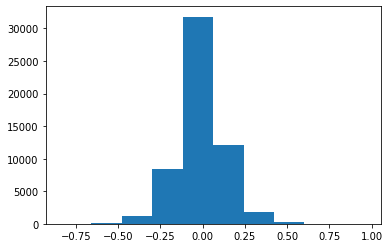

In [20]:
plt.hist(data.SentimentTitle)

(array([3.0000e+01, 3.6600e+02, 3.5130e+03, 1.7183e+04, 2.6092e+04,
        7.6890e+03, 9.6300e+02, 8.3000e+01, 8.0000e+00, 5.0000e+00]),
 array([-0.75535505, -0.58335492, -0.41135479, -0.23935466, -0.06735453,
         0.1046456 ,  0.27664572,  0.44864585,  0.62064598,  0.79264611,
         0.96464624]),
 <a list of 10 Patch objects>)

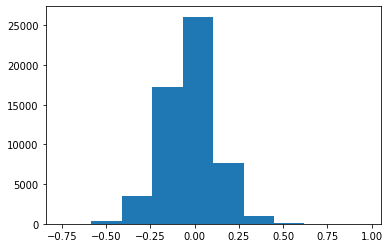

In [21]:
plt.hist(data.SentimentHeadline)

## Model training


In [22]:
training_title=data[['Source', 'Topic','Facebook', 'GooglePlus', 'LinkedIn','polarity_t', 'subjectivity_t','weekday', 'hour']]
training_head=data[['Source', 'Topic','Facebook', 'GooglePlus', 'LinkedIn','polarity_h', 'subjectivity_h','weekday', 'hour']]

In [26]:
X_train, X_test, y_train, y_test = train_test_split(training_title,data['SentimentTitle'],random_state=1)
clf1 = LinearSVR(C=0.3)
clf1.fit(X_train, y_train)

y_pred1 = clf1.predict(X_test)
mae1 = mean_absolute_error(y_pred1, y_test)
print('MAE:', 1 - mae1)

MAE: 0.844095338407022


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [27]:
X_train, X_test, y_train, y_test = train_test_split(training_head,data['SentimentHeadline'],random_state=1)
clf2 = LinearSVR(C=0.3)
clf2.fit(X_train, y_train)

y_pred2 = clf2.predict(X_test)
mae2 = mean_absolute_error(y_pred2, y_test)
print('MAE:', 1 - mae2)

MAE: 0.8221845424255613


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [28]:
print('MAE:', 1 - ((0.4 * mae1) + (0.6 * mae2)))

MAE: 0.8309488608181456
